In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 

from datetime import datetime

import tensorflow as tf
import keras


Using TensorFlow backend.


In [2]:
dir_path = os.getcwd()
dir_path

'/Users/nicolasmaquaire/Dropbox/KLoop/Dev/190209_MLEnvs'

In [3]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
cifar10_1 = unpickle('datasets/cifar-10/data_batch_1')

In [6]:
cifar10_dataset_folder_path = 'datasets/cifar-10/'

In [7]:
list(cifar10_1.keys())

[b'batch_label', b'labels', b'data', b'filenames']

In [8]:
len(cifar10_1[b'data']),len(cifar10_1[b'labels'])

(10000, 10000)

In [9]:
cifar10_1[b'batch_label']

b'training batch 1 of 5'

In [10]:
cifar10_Label_names = unpickle('datasets/cifar-10/batches.meta')
cifar10_Label_names[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [11]:
label_names = []
for x in cifar10_Label_names[b'label_names']:
    label = x.decode()
    label_names.append(label)

In [12]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [13]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [14]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


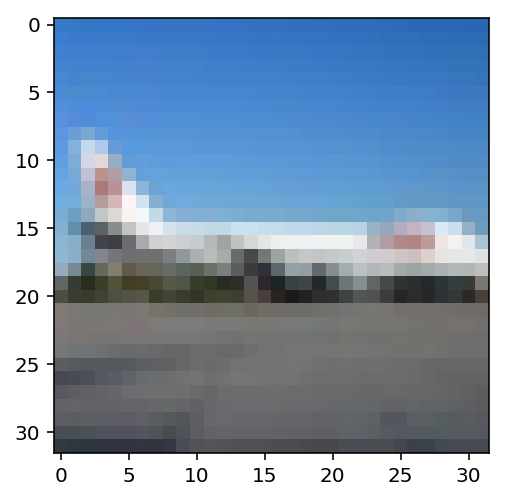

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [16]:
def normalize(x):

    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [17]:
def one_hot_encode(x):

    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [18]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    # one hot encoding only for categorical_crossentropy and categorical_accuracy
    #labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

In [19]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    all_features = []
    all_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
        all_features.extend(features[:-index_of_validation])
        all_labels.extend(labels[:-index_of_validation])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'datasets/preprocess_validation.p')
                                 
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(all_features), np.array(all_labels),
                         'datasets/preprocess_all.p')
    

In [20]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [21]:
valid_features, valid_labels = pickle.load(open('datasets/preprocess_validation.p', mode='rb'))
print(valid_features.dtype)
print(valid_features.shape)

float64
(5000, 32, 32, 3)


In [22]:
train_features, train_labels = pickle.load(open('datasets/preprocess_all.p', mode='rb'))
print(train_features.dtype)
print(train_features.shape)

float64
(45000, 32, 32, 3)


In [23]:
def build_model(target_size):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(target_size, target_size, 3)))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=(target_size, target_size, 3)))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=(target_size, target_size, 3)))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))

    return model


In [24]:
model = build_model(32)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [26]:
def trainableLayers(model):
    
        for layer in model.layers:
            layer.trainable = True  
    

In [27]:
trainableLayers(model)

In [28]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy')

In [29]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0)

In [30]:
def fit_all_batches(xEpochs):

        model.fit(
            train_features, train_labels,
            epochs=xEpochs,
            batch_size=32,
            validation_data=(valid_features, valid_labels),
            callbacks=[tensorboard] #[tensorboard, earlystopper]
        )

In [31]:
# For a better accuracy, increase the number of Epochs
fit_all_batches(20)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 412s 9ms/sample - loss: 2.0288 - sparse_categorical_accuracy: 0.2158 - val_loss: 1.6552 - val_sparse_categorical_accuracy: 0.3456
Epoch 2/20
45000/45000 [==============================] - 405s 9ms/sample - loss: 1.8163 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.5095 - val_sparse_categorical_accuracy: 0.4334
Epoch 3/20
45000/45000 [==============================] - 397s 9ms/sample - loss: 1.3787 - sparse_categorical_accuracy: 0.5117 - val_loss: 1.0513 - val_sparse_categorical_accuracy: 0.6376
Epoch 4/20
45000/45000 [==============================] - 402s 9ms/sample - loss: 1.1237 - sparse_categorical_accuracy: 0.6083 - val_loss: 0.9350 - val_sparse_categorical_accuracy: 0.6796
Epoch 5/20
45000/45000 [==============================] - 401s 9ms/sample - loss: 0.9749 - sparse_categorical_accuracy: 0.6649 - val_loss: 0.8104 - val_sparse_categorical_accuracy: 0.7290
Epoch 6/20


In [32]:
sample_image = valid_features[3:4]

In [33]:
sample_image.shape

(1, 32, 32, 3)

In [34]:
y_pred = model.predict(sample_image)
y_pred

array([[5.2165799e-19, 1.7810872e-09, 3.6717132e-24, 8.2578149e-23,
        4.9668584e-29, 6.9886677e-23, 1.0492857e-25, 9.6482272e-28,
        2.4515497e-16, 1.0000000e+00]], dtype=float32)

In [35]:
y_pred_flat = y_pred.flatten()
y_pred_flat

array([5.2165799e-19, 1.7810872e-09, 3.6717132e-24, 8.2578149e-23,
       4.9668584e-29, 6.9886677e-23, 1.0492857e-25, 9.6482272e-28,
       2.4515497e-16, 1.0000000e+00], dtype=float32)

In [36]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [37]:
def predictions():
    
    sample_image = valid_features[107:108]
    print(sample_image.shape)
    y_pred = model.predict(sample_image)
    y_pred_flat = y_pred.flatten()
    
    results = np.column_stack((label_names, y_pred_flat))
    print(results)
    plt.imshow(valid_features[107])

In [38]:
valid_features[107].shape

(32, 32, 3)

(1, 32, 32, 3)
[['airplane' '3.3353663e-06']
 ['automobile' '5.2709706e-06']
 ['bird' '0.0001579317']
 ['cat' '0.93337053']
 ['deer' '0.00016205886']
 ['dog' '0.053339865']
 ['frog' '0.012901713']
 ['horse' '2.7413e-05']
 ['ship' '4.6713003e-06']
 ['truck' '2.7315138e-05']]


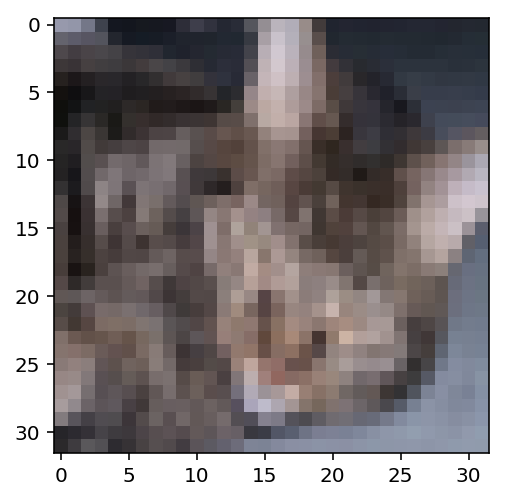

In [39]:
predictions()

In [40]:
def nottrainableLayers(model):
    
        for layer in model.layers:
            layer.trainable = False  

In [41]:
nottrainableLayers(model)

In [42]:
for l in model.layers:
    print(l.name, l.trainable)

batch_normalization_v1 False
conv2d False
max_pooling2d False
dropout False
batch_normalization_v1_1 False
conv2d_1 False
max_pooling2d_1 False
dropout_1 False
batch_normalization_v1_2 False
conv2d_2 False
max_pooling2d_2 False
dropout_2 False
flatten False
dense False
activation False
dropout_3 False
dense_1 False
activation_1 False


In [43]:
keras_file = "models/keras_CIFAR_Seq_Sparse_model/keras_CIFAR_Seq_Sparse.h5"
model.save(keras_file)

In [44]:
# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
converter.post_training_quantize=True
tflite_model = converter.convert()
open("models/keras_CIFAR_Seq_Sparse_model/keras_CIFAR_Seq_Sparse.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 22 variables.
INFO:tensorflow:Converted 22 variables to const ops.


2088640